In [195]:
import tensorflow as tf
import numpy as np
import skimage.io as image
import PIL.Image
from skimage.transform import resize
import sys
import os
from nst_support_functions import *
import IPython.display as display

print (tf.__version__)

2.1.0-dev20191121


In [196]:
def vgg_layers(layers):
    vgg = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_tensor=tf.keras.Input(shape=(224, 224, 3)))
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layers]

    model = tf.keras.Model([vgg.input], outputs = outputs, name='VGG19')
    return model

In [9]:
def total_loss(inputs, content_outputs, style_outputs):
    content_input, style_input, generated_input = inputs
    
    content = tf.keras.Model([model.input], outputs = content_outputs, name='VGG19')
    content_output = a_content(content_input)
    generated_output = a_content(generated_input)
    
    style = tf.keras.Model(inputs=[model.input], outputs=style_layer_outputs, name='VGG19')
    style_outputs = style(style_input)
    generated_outputs = style(generated_input)
    
    J_content = compute_content_cost(content_output, generated_output)
    J_style = compute_style_cost(model, style_input, generated_input, style_layers, coefs)
    J_total = total_cost(J_content, J_style)
    return J_total

In [40]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [12]:
def gram(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [13]:
class StyleContentModel(tf.keras.models.Model):

    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = stylde_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        preprocessed = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        
        style_outputs = [gram(style_output) for style_output in style_outputs]

        content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

In [300]:
style = style_image.astype(float)
style_tensor = tf.expand_dims(tf.constant(style), 0)
print(style_tensor.shape)

style_targets = extractor(style_tensor)['style']
content_targets = extractor(content_tensor)['content']

(1, 244, 244, 3)


In [253]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Better Version

In [188]:
def prep_image(content_image, style_image):
    content = resize(content_image, (300, 300))
    print (f'\nResizing content image from {content_image.shape} to (300, 300, 3)')
    # content = reshape_and_normalize_image(content)
    content = content.astype(float)
    content_tensor = tf.expand_dims(tf.constant(content), 0)
    print (f'\nExpanding content image to shape {content_tensor.shape}')
    
    style = resize(style_image, (300, 300))
    print (f'\nResizing style image from {style_image.shape} to (300, 300, 3)')
    # style = reshape_and_normalize_image(style)
           
    style = style.astype(float)
    style_tensor = tf.expand_dims(tf.constant(style), 0)
    print (f'\nExpanding style image to shape {style_tensor.shape}')
    
    return content_tensor, style_tensor

In [189]:
def style_content_loss(outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])

    loss =  (style_weight * style_loss) + (content_weight * content_loss)
    return loss

In [190]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

In [191]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [192]:
@tf.function()
def training_step(image, model_targets, optimizer):
    model = model_targets['model']
    style_targets = model_targets['style']
    content_targets = model_targets['content']
    
    with tf.GradientTape() as tape:
        outputs = model(image)
        loss = style_content_loss(outputs, style_targets, content_targets)
        loss += tf.cast(total_variation_weight * tf.image.total_variation(image), dtype='float32')

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(image)

In [193]:
def neural_style_transfer(content_image, style_image, layers):
    prepped_content, prepped_style = prep_image(content_image, style_image)
    content_layers, style_layers = layers
    
    style_content_model = StyleContentModel(style_layers, content_layers)
    style_targets = style_content_model(prepped_style)['style']
    content_targets =  style_content_model(prepped_content)['content']
    
    model_targets = {'model': style_content_model, 'style':style_targets, 'content':content_targets}
    
    image = tf.Variable(prepped_content)
    
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    
    # test
    for i in range(1, 1000):
        training_step(image, model_targets, opt)
    return image
            

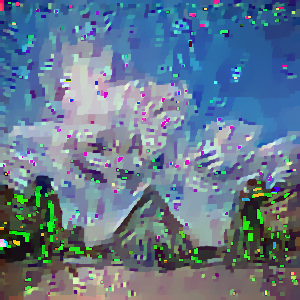

In [194]:
style_image = image.imread('./images/starrynight.jpg')
content_image = image.imread('./images/louvre.jpg')

style_weight=5
content_weight=5
total_variation_weight=30

content_layers = ['block4_conv2']

style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

layers = [content_layers, style_layers]

image = neural_style_transfer(content_image, style_image, layers)

display.clear_output(wait=True)
display.display(tensor_to_image(image))